## Mental Health Classification Using CANINE Transformer

Dataset Source: https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus

#### Import Necessary Libraries

In [1]:
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import Trainer, TrainingArguments, set_seed
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

import datasets
from datasets import Dataset, DatasetDict

import evaluate
import torch

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
n = 20

print("Library/Language:".rjust(n), "Version")
print("Python:".rjust(n), sys.version[0:6])
print("NumPy:".rjust(n), np.__version__)
print("Pandas:".rjust(n), pd.__version__)
print("Torch:".rjust(n), torch.__version__)
print("Datasets:".rjust(n), datasets.__version__)
print("Transformers:".rjust(n), transformers.__version__)
print("Evaluate:".rjust(n), evaluate.__version__)

   Library/Language: Version
             Python: 3.9.7 
              NumPy: 1.23.3
             Pandas: 1.4.4
              Torch: 1.12.1
           Datasets: 2.8.0
       Transformers: 4.26.1
           Evaluate: 0.2.2


#### Ingest & Preprocess Dataset

In [3]:
data = pd.read_csv("mental_health.csv")

data = data.dropna()

data = data.drop_duplicates(subset=["text"], ignore_index=True)

data

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
...,...,...
27967,posting everyday people stop caring religion ...,0
27968,okay definetly need hear guys opinion ive pret...,0
27969,cant get dog think ill kill myselfthe last thi...,1
27970,whats point princess bridei really think like ...,1


#### Display Information About Dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27972 entries, 0 to 27971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27972 non-null  object
 1   label   27972 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.2+ KB


#### Visualize: Word Length of Input Samples

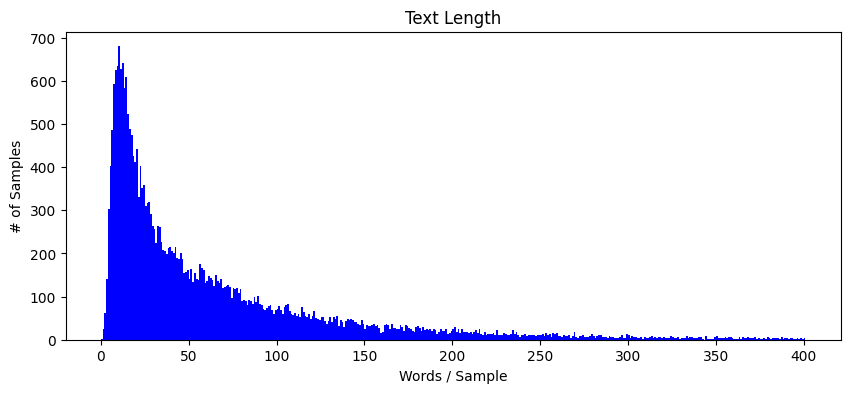

In [5]:
data['text_len'] = data['text'].str.split().apply(len)

n = 401

data.hist("text_len", grid=False, color="Blue", figsize=(10,4), range=(0,n), bins=n)

plt.suptitle('')
plt.ylabel('# of Samples')

plt.xlabel('Words / Sample')
plt.title('Text Length')

plt.show()

#### How Long is Longest Input Sample (in Words)

In [6]:
print(f"The longest news article is approximately {max(data['text_len'])} words in length")

The longest news article is approximately 2676 words in length


#### Number of Samples in Each Class

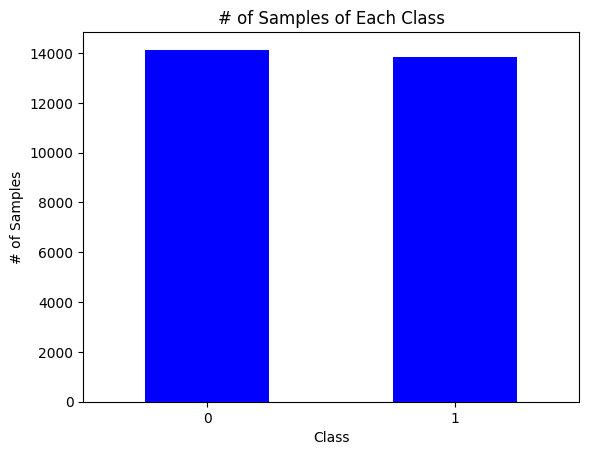

In [7]:
class_counts = data.groupby("label").count()

class_counts.plot.bar(color="blue")
plt.suptitle('')
plt.title('# of Samples of Each Class')
plt.xlabel('Class')
plt.ylabel('# of Samples')
plt.legend().remove()
plt.xticks(rotation = 0)
plt.show()

#### Trim Overly Lengthy Input Samples

In [8]:
MAX_INPUT_LENGTH = 100

data = data[data['text_len'] < (MAX_INPUT_LENGTH + 1)]
data = data.drop(columns=['text_len'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22013 entries, 0 to 27971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    22013 non-null  object
 1   label   22013 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 515.9+ KB


#### Convert DataFrame to Dataset

In [9]:
dataset = Dataset.from_pandas(data)

#### Split Dataset into Training/Evaluation Datasets

In [10]:
train_eval = dataset.train_test_split(train_size=0.80)

ds = DatasetDict({
    'train': train_eval['train'], 
    'eval': train_eval['test']
    })

print('Training data shape:', ds['train'].shape)
print('Validation data shape:', ds['eval'].shape)

Training data shape: (17610, 3)
Validation data shape: (4403, 3)


#### Basic Values/Constants

In [11]:
MODEL_CKPT = "google/canine-c"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Mental_Health_Classification"

NUM_OF_EPOCHS = 2

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

DEVICE = torch.device("cpu")
set_seed = 42

LR = 2e-5
BATCH_SIZE = 16

#### Tokenize Dataset

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

train_ds = ds['train'].map(lambda examples: tokenizer(examples['text'], 
                                                      padding="max_length", 
                                                      truncation=True),
                        batched=True)

train_ds.set_format(type="torch", columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

eval_ds = ds['eval'].map(lambda examples: tokenizer(examples['text'], 
                                                    padding="max_length", 
                                                    truncation=True),
                         batched=True)

eval_ds.set_format(type="torch", columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

#### Some Information ABout Datasets

In [13]:
print('Training data shape:', train_ds.shape)
print('Validation data shape:', eval_ds.shape)

print(train_ds.features)
print(train_ds)

Training data shape: (17610, 6)
Validation data shape: (4403, 6)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17610
})


#### Instantiate Model

In [14]:
model = (
    AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT)
    ).to(DEVICE)

Some weights of CanineForSequenceClassification were not initialized from the model checkpoint at google/canine-c and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Function to Compute Metrics

In [15]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["precision"]
    
    return {"accuracy" : accuracy, 
            "F1" : f1_score,
            "Recall" : recall,
            "Precision" : precision,
            }

#### Instantiate Data Collator

In [16]:
data_collator = DataCollatorWithPadding(tokenizer, 
                                        padding=True)

#### Define TrainingArguments

In [17]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    logging_first_step=True,
    logging_strategy=STRATEGY,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    report_to=REPORTS_TO,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [18]:
trainer = Trainer(model=model, 
                  args=args, 
                  compute_metrics=compute_metrics,
                  train_dataset=train_ds, 
                  eval_dataset=eval_ds, 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/canine-c-Mental_Health_Classification into local empty directory.


#### Train Model

In [19]:
training_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `CanineForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `CanineForSequenceClassification.forward`,  you can safely ignore this message.
/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17610
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2202
  Number of trainable parameters = 132084482


  0%|          | 0/2202 [00:00<?, ?it/s]

{'loss': 0.6629, 'learning_rate': 1.9990917347865578e-05, 'epoch': 0.0}


The following columns in the evaluation set don't have a corresponding argument in `CanineForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `CanineForSequenceClassification.forward`,  you can safely ignore this message.


{'loss': 0.3429, 'learning_rate': 1e-05, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 4403
  Batch size = 16


  0%|          | 0/276 [00:00<?, ?it/s]

Saving model checkpoint to canine-c-Mental_Health_Classification/checkpoint-1101
Configuration saved in canine-c-Mental_Health_Classification/checkpoint-1101/config.json


{'eval_loss': 0.26399940252304077, 'eval_accuracy': 0.9037020213490802, 'eval_F1': 0.8803611738148985, 'eval_Recall': 0.8258337744838539, 'eval_Precision': 0.9425981873111783, 'eval_runtime': 29738.1949, 'eval_samples_per_second': 0.148, 'eval_steps_per_second': 0.009, 'epoch': 1.0}


Model weights saved in canine-c-Mental_Health_Classification/checkpoint-1101/pytorch_model.bin
tokenizer config file saved in canine-c-Mental_Health_Classification/checkpoint-1101/tokenizer_config.json
Special tokens file saved in canine-c-Mental_Health_Classification/checkpoint-1101/special_tokens_map.json
tokenizer config file saved in canine-c-Mental_Health_Classification/tokenizer_config.json
Special tokens file saved in canine-c-Mental_Health_Classification/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `CanineForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `CanineForSequenceClassification.forward`,  you can safely ignore this message.


{'loss': 0.1923, 'learning_rate': 0.0, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 4403
  Batch size = 16


  0%|          | 0/276 [00:00<?, ?it/s]

Saving model checkpoint to canine-c-Mental_Health_Classification/checkpoint-2202
Configuration saved in canine-c-Mental_Health_Classification/checkpoint-2202/config.json


{'eval_loss': 0.24188289046287537, 'eval_accuracy': 0.9225528049057461, 'eval_F1': 0.9095730575444179, 'eval_Recall': 0.9078877713075701, 'eval_Precision': 0.9112646121147715, 'eval_runtime': 30469.9578, 'eval_samples_per_second': 0.145, 'eval_steps_per_second': 0.009, 'epoch': 2.0}


Model weights saved in canine-c-Mental_Health_Classification/checkpoint-2202/pytorch_model.bin
tokenizer config file saved in canine-c-Mental_Health_Classification/checkpoint-2202/tokenizer_config.json
Special tokens file saved in canine-c-Mental_Health_Classification/checkpoint-2202/special_tokens_map.json
tokenizer config file saved in canine-c-Mental_Health_Classification/tokenizer_config.json
Special tokens file saved in canine-c-Mental_Health_Classification/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from canine-c-Mental_Health_Classification/checkpoint-2202 (score: 0.24188289046287537).


{'train_runtime': 853263.9942, 'train_samples_per_second': 0.041, 'train_steps_per_second': 0.003, 'train_loss': 0.26774565717180027, 'epoch': 2.0}


#### Save & Log Training Model & Metrics

In [20]:
trainer.save_model()
trainer.log_metrics("train", training_results.metrics)
trainer.save_metrics("train", training_results.metrics)
trainer.save_state()

Saving model checkpoint to canine-c-Mental_Health_Classification
Configuration saved in canine-c-Mental_Health_Classification/config.json
Model weights saved in canine-c-Mental_Health_Classification/pytorch_model.bin
tokenizer config file saved in canine-c-Mental_Health_Classification/tokenizer_config.json
Special tokens file saved in canine-c-Mental_Health_Classification/special_tokens_map.json
Saving model checkpoint to canine-c-Mental_Health_Classification
Configuration saved in canine-c-Mental_Health_Classification/config.json
Model weights saved in canine-c-Mental_Health_Classification/pytorch_model.bin
tokenizer config file saved in canine-c-Mental_Health_Classification/tokenizer_config.json
Special tokens file saved in canine-c-Mental_Health_Classification/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/504M [00:00<?, ?B/s]

Upload file runs/Mar31_21-14-08_Lees-Air/events.out.tfevents.1680315255.Lees-Air.71304.0:   0%|          | 1.0…

To https://huggingface.co/DunnBC22/canine-c-Mental_Health_Classification
   32ba3a1..b287051  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9225528049057461}, {'name': 'F1', 'type': 'f1', 'value': 0.9095730575444179}, {'name': 'Recall', 'type': 'recall', 'value': 0.9078877713075701}, {'name': 'Precision', 'type': 'precision', 'value': 0.9112646121147715}]}
To https://huggingface.co/DunnBC22/canine-c-Mental_Health_Classification
   b287051..7102519  main -> main



***** train metrics *****
  epoch                    =                 2.0
  train_loss               =              0.2677
  train_runtime            = 9 days, 21:01:03.99
  train_samples_per_second =               0.041
  train_steps_per_second   =               0.003


#### Calculate, Save, & Log Evaluation Metrics

In [21]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

The following columns in the evaluation set don't have a corresponding argument in `CanineForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `CanineForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4403
  Batch size = 16


  0%|          | 0/276 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        2.0
  eval_F1                 =     0.9096
  eval_Precision          =     0.9113
  eval_Recall             =     0.9079
  eval_accuracy           =     0.9226
  eval_loss               =     0.2419
  eval_runtime            = 8:02:32.80
  eval_samples_per_second =      0.152
  eval_steps_per_second   =       0.01


#### Push Model to Hub

In [22]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to canine-c-Mental_Health_Classification
Configuration saved in canine-c-Mental_Health_Classification/config.json
Model weights saved in canine-c-Mental_Health_Classification/pytorch_model.bin
tokenizer config file saved in canine-c-Mental_Health_Classification/tokenizer_config.json
Special tokens file saved in canine-c-Mental_Health_Classification/special_tokens_map.json


Upload file .DS_Store: 100%|##########| 6.00k/6.00k [00:00<?, ?B/s]

Upload file runs/.DS_Store: 100%|##########| 6.00k/6.00k [00:00<?, ?B/s]

Upload file runs/Mar31_21-14-08_Lees-Air/events.out.tfevents.1681198309.Lees-Air.71304.2: 100%|##########| 512…

To https://huggingface.co/DunnBC22/canine-c-Mental_Health_Classification
   7102519..d80cf04  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9225528049057461}, {'name': 'F1', 'type': 'f1', 'value': 0.9095730575444179}, {'name': 'Recall', 'type': 'recall', 'value': 0.9078877713075701}, {'name': 'Precision', 'type': 'precision', 'value': 0.9112646121147715}]}


'https://huggingface.co/DunnBC22/canine-c-Mental_Health_Classification/commit/d80cf04469e26cdaf180ca577c4e75ee034af3fb'

### Notes & Other Takeaways From This Project

***
- I am curious how this tranformer compares with BERT and others.

***

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2103-06874,
  author    = {Jonathan H. Clark and Dan Garrette and Iulia Turc and John Wieting}, title = {{CANINE:} Pre-training an Efficient Tokenization-Free Encoder for Language Representation}, journal = {CoRR}, volume = {abs/2103.06874}, year ={2021}, url = {https://arxiv.org/abs/2103.06874}, archivePrefix = {arXiv}, eprint = {2103.06874}, timestamp = {Tue, 16 Mar 2021 11:26:59 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-2103-06874.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}
